# 1a-flights-histogram.ipynb

This notebook covers how to get data via `eland` (https://github.com/elastic/eland) from Elasticsearch and discusses some different approaches how to visualize small multiples of binned histograms with `eland` and Altair. It covers the basic requirements to successfully create and publish a custom visualization from Jupyter to Kibana.

In [22]:
import datetime
import pandas as pd
import altair as alt
import eland as ed
from elasticsearch import Elasticsearch
import elastic_transport
import json
import numpy as np
import matplotlib.pyplot as plt
import urllib3
import logging
import requests

alt.data_transformers.disable_max_rows()
logging.getLogger("elastic_transport").setLevel(logging.ERROR)

# Suppress insecure SSL connection warnings
# In dev environments with the `verify_certs=False`
# you might want to reduce those warnings.
#urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
#urllib3.disable_warnings(elastic_transport.SecurityWarning)

#### Connect to the 'flights' example dataset, can be installed via Kibana.

In [36]:
with open('config.json') as config_file:
  es_config = json.load(config_file)

# First instantiate an 'Elasticsearch' instance with the supplied config
es = Elasticsearch(
    hosts=[es_config['es_client']],
    basic_auth=[
        es_config['user'],
        es_config['password']
    ],
    # Only in development environments with self signed certificates fall back to use `verify_certs=False`
    # verify_certs=False
)

df = ed.DataFrame(es, 'kibana_sample_data_flights')
df.head()

AvgTicketPrice  Cancelled           Carrier  \
FK7wlYUB84Z0EQSGKFH6      841.265642      False   Kibana Airlines   
Fa7wlYUB84Z0EQSGKFH6      882.982662      False  Logstash Airways   
Fq7wlYUB84Z0EQSGKFH6      190.636904      False  Logstash Airways   
F67wlYUB84Z0EQSGKFH6      181.694216       True   Kibana Airlines   
GK7wlYUB84Z0EQSGKFH6      730.041778      False   Kibana Airlines   

                                                              Dest  \
FK7wlYUB84Z0EQSGKFH6  Sydney Kingsford Smith International Airport   
Fa7wlYUB84Z0EQSGKFH6                     Venice Marco Polo Airport   
Fq7wlYUB84Z0EQSGKFH6                     Venice Marco Polo Airport   
F67wlYUB84Z0EQSGKFH6                   Treviso-Sant'Angelo Airport   
GK7wlYUB84Z0EQSGKFH6          Xi'an Xianyang International Airport   

                     DestAirportID DestCityName DestCountry  \
FK7wlYUB84Z0EQSGKFH6           SYD       Sydney          AU   
Fa7wlYUB84Z0EQSGKFH6          VE05       Venice          IT   
Fq7wlYUB84Z0EQSGKFH6          VE05       Venice          IT   
F67wlYUB84Z0EQSGKFH6          TV01      Treviso          IT   
GK7wlYUB84Z0EQSGKFH6           XIY        Xi'an          CN   

                                                      DestLocation DestRegion  \
FK7wlYUB84Z0EQSGKFH6  {'lat': '-33.94609833', 'lon': '151.177002'}      SE-BD   
Fa7wlYUB84Z0EQSGKFH6        {'lat': '45.505299', 'lon': '12.3519'}      IT-34   
Fq7wlYUB84Z0EQSGKFH6        {'lat': '45.505299', 'lon': '12.3519'}      IT-34   
F67wlYUB84Z0EQSGKFH6        {'lat': '45.648399', 'lon': '12.1944'}      IT-34   
GK7wlYUB84Z0EQSGKFH6     {'lat': '34.447102', 'lon': '108.751999'}      SE-BD   

                     DestWeather  ...  FlightTimeMin  \
FK7wlYUB84Z0EQSGKFH6        Rain  ...    1030.770416   
Fa7wlYUB84Z0EQSGKFH6       Sunny  ...     464.389481   
Fq7wlYUB84Z0EQSGKFH6      Cloudy  ...       0.000000   
F67wlYUB84Z0EQSGKFH6       Clear  ...     222.749059   
GK7wlYUB84Z0EQSGKFH6       Clear  ...     785.779071   

                                                              Origin  \
FK7wlYUB84Z0EQSGKFH6                       Frankfurt am Main Airport   
Fa7wlYUB84Z0EQSGKFH6                 Cape Town International Airport   
Fq7wlYUB84Z0EQSGKFH6                       Venice Marco Polo Airport   
F67wlYUB84Z0EQSGKFH6                    Naples International Airport   
GK7wlYUB84Z0EQSGKFH6  Licenciado Benito Juarez International Airport   

                      OriginAirportID     OriginCityName OriginCountry  \
FK7wlYUB84Z0EQSGKFH6              FRA  Frankfurt am Main            DE   
Fa7wlYUB84Z0EQSGKFH6              CPT          Cape Town            ZA   
Fq7wlYUB84Z0EQSGKFH6             VE05             Venice            IT   
F67wlYUB84Z0EQSGKFH6             NA01             Naples            IT   
GK7wlYUB84Z0EQSGKFH6             AICM        Mexico City            MX   

                                                     OriginLocation  \
FK7wlYUB84Z0EQSGKFH6        {'lat': '50.033333', 'lon': '8.570556'}   
Fa7wlYUB84Z0EQSGKFH6  {'lat': '-33.96480179', 'lon': '18.60169983'}   
Fq7wlYUB84Z0EQSGKFH6         {'lat': '45.505299', 'lon': '12.3519'}   
F67wlYUB84Z0EQSGKFH6         {'lat': '40.886002', 'lon': '14.2908'}   
GK7wlYUB84Z0EQSGKFH6        {'lat': '19.4363', 'lon': '-99.072098'}   

                      OriginRegion        OriginWeather dayOfWeek  \
FK7wlYUB84Z0EQSGKFH6         DE-HE                Sunny         0   
Fa7wlYUB84Z0EQSGKFH6         SE-BD                Clear         0   
Fq7wlYUB84Z0EQSGKFH6         IT-34                 Rain         0   
F67wlYUB84Z0EQSGKFH6         IT-72  Thunder & Lightning         0   
GK7wlYUB84Z0EQSGKFH6        MX-DIF        Damaging Wind         0   

                               timestamp  
FK7wlYUB84Z0EQSGKFH6 2023-01-02 00:00:00  
Fa7wlYUB84Z0EQSGKFH6 2023-01-02 18:27:00  
Fq7wlYUB84Z0EQSGKFH6 2023-01-02 17:11:14  
F67wlYUB84Z0EQSGKFH6 2023-01-02 10:33:28  
GK7wlYUB84Z0EQSGKFH6 2023-01-02 05:13:00  

[5 r

#### Output the data frame's info. Note its low memory footprint because of the data residing in Elasticsearch.

In [3]:
df.info()

<class 'eland.dataframe.DataFrame'>
Index: 13059 entries, FK7wlYUB84Z0EQSGKFH6 to Fq7wlYUB84Z0EQSGMYQh
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AvgTicketPrice      13059 non-null  float64       
 1   Cancelled           13059 non-null  bool          
 2   Carrier             13059 non-null  object        
 3   Dest                13059 non-null  object        
 4   DestAirportID       13059 non-null  object        
 5   DestCityName        13059 non-null  object        
 6   DestCountry         13059 non-null  object        
 7   DestLocation        13059 non-null  object        
 8   DestRegion          13059 non-null  object        
 9   DestWeather         13059 non-null  object        
 10  DistanceKilometers  13059 non-null  float64       
 11  DistanceMiles       13059 non-null  float64       
 12  FlightDelay         13059 non-null  bool          
 13  FlightDelayMin     

#### Next we output small multiples of binned histograms via matplotlib.

The following code is great because it's short and concise. However, we cannot deploy these bitmap based charts to Kibana and make them dynamic. And as of Elastic Stack 7.9, these kind of charts (both small multiples and binned histograms) are a bit cumbersome to create with native Kibana tools.

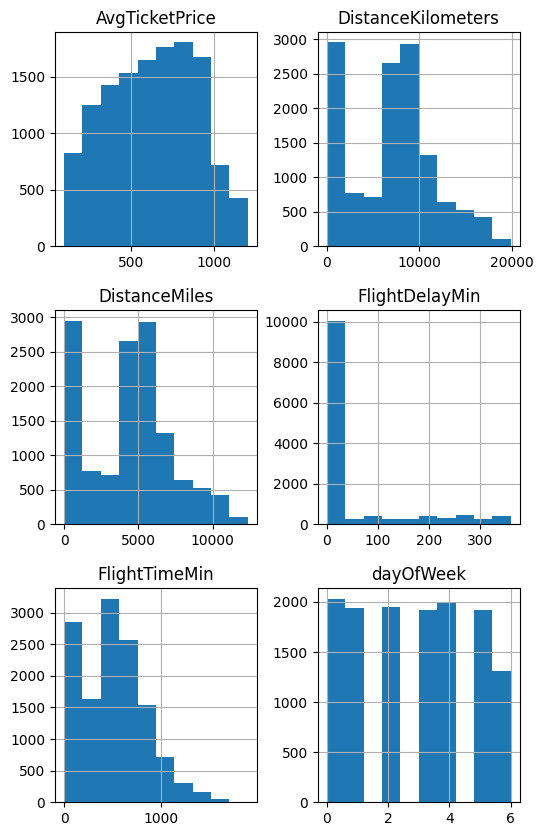

In [4]:
df_number = df.select_dtypes(include=np.number)
df_number.hist(figsize=[6,10])
plt.show()

Let's try to create the same chart type using Altair, here's a most basic example with dummy data:

In [5]:
source = pd.DataFrame({
    'a': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
    'b': [28, 55, 43, 91, 81, 53, 19, 87, 52]
})

alt.Chart(source, height=160, width=120).mark_bar().encode(
    x='a',
    y='b'
)

/Users/walterra/dev/jupyter2kibana/env-jupyter2kibana/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

To move forward, we convert the eland based data frame to a native pandas one.
Note how this one requires more memory because it's kept locally now.

In [6]:
df_altair = ed.eland_to_pandas(df_number)
df_altair.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13059 entries, FK7wlYUB84Z0EQSGKFH6 to Fq7wlYUB84Z0EQSGMYQh
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   AvgTicketPrice      13059 non-null  float64
 1   DistanceKilometers  13059 non-null  float64
 2   DistanceMiles       13059 non-null  float64
 3   FlightDelayMin      13059 non-null  int64  
 4   FlightTimeMin       13059 non-null  float64
 5   dayOfWeek           13059 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 714.2+ KB


In [7]:
df_altair.head()

AvgTicketPrice  DistanceKilometers  DistanceMiles  \
FK7wlYUB84Z0EQSGKFH6      841.265642        16492.326654   10247.856676   
Fa7wlYUB84Z0EQSGKFH6      882.982662         8823.400140    5482.606665   
Fq7wlYUB84Z0EQSGKFH6      190.636904            0.000000       0.000000   
F67wlYUB84Z0EQSGKFH6      181.694216          555.737767     345.319439   
GK7wlYUB84Z0EQSGKFH6      730.041778        13358.244200    8300.428125   

                      FlightDelayMin  FlightTimeMin  dayOfWeek  
FK7wlYUB84Z0EQSGKFH6               0    1030.770416          0  
Fa7wlYUB84Z0EQSGKFH6               0     464.389481          0  
Fq7wlYUB84Z0EQSGKFH6               0       0.000000          0  
F67wlYUB84Z0EQSGKFH6             180     222.749059          0  
GK7wlYUB84Z0EQSGKFH6               0     785.779071          0

The above cell shows the data frame structure with the same schema as it was stored in Elasticsearch.
This type of format could be used, but it's more cumbersome to work with in Altair/Vega.
For more details, see Altair's docs on "Long-form vs. Wide-form Data" https://altair-viz.github.io/user_guide/data.html#long-form-vs-wide-form-data

The next cell converts the data frame to "long form" which makes it more easy to split data based on an entity/attribute.

In [8]:
df_melt = df_altair.melt(var_name='attribute', value_name='value')
df_melt.head()

attribute       value
0  AvgTicketPrice  841.265642
1  AvgTicketPrice  882.982662
2  AvgTicketPrice  190.636904
3  AvgTicketPrice  181.694216
4  AvgTicketPrice  730.041778

Finally we're able to recreate the original chart with Altair/Vega:

In [9]:
data = df_melt

chart = alt.Chart(data).mark_bar().encode(
    alt.X('value:Q', bin=True, title=''),
    alt.Y('count()', title=''),
    tooltip=[
        alt.Tooltip('value:Q', bin=True, title='x'),
        alt.Tooltip('count()', title='y')
    ]
).properties(
    width=130,
    height=130
)

alt.ConcatChart(
    concat=[
      chart.transform_filter(alt.datum.attribute == value).properties(title=value)
      for value in sorted(data.attribute.unique())
    ],
    columns=3
).resolve_axis(
    x='independent',
    y='independent'
).resolve_scale(
    x='independent', 
    y='independent'
)

/Users/walterra/dev/jupyter2kibana/env-jupyter2kibana/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.ConcatChart(...)

To achieve the same with the data still in Elasticsearch, we need to change the example using a remote URL.

Note this is meant as a middle step towards our final chart specification for demonstration purposes. This one doesn't work with security enabled for Elasticsearch, so take care. You'll need to add the following settings to your `elasticsearch.yml`, again take care, this isn't recommended for production configs at all:

```
xpack.security.enabled: false
http.cors.allow-origin: "/.*/"
http.cors.enabled: true
```

The other difference to the previous code is that instead of using panda's `.melt()` we're using Vega's `.transform_fold()` to transpose the data from wide to long form.

The important bit is that we're using Altair only to do data transformations and not raw Python or pandas code, otherwise we're not able to publish the chart specification to Kibana later on.

In [53]:
url = 'http://localhost:9220/kibana_sample_data_flights/_search?size=10000'
url_data = alt.Data(url=url, format=alt.DataFormat(property='hits.hits',type='json'))

fields = [
    'AvgTicketPrice',
    'DistanceKilometers',
    'DistanceMiles',
    'FlightDelayMin',
    'FlightTimeMin',
    'dayOfWeek'
]

rename_dict = dict((a, 'datum._source.'+a) for a in fields)

url_chart = alt.Chart(url_data).transform_calculate(**rename_dict).transform_fold(
    fields,
    as_=['attribute', 'value']
).mark_bar().encode(
    alt.X('value:Q', bin=True, title=''),
    alt.Y('count()', title=''),
    tooltip=[
        alt.Tooltip('value:Q', bin=True, title='x'),
        alt.Tooltip('count()', title='y')
    ]
).properties(
    width=150,
    height=150
)

url_charts = alt.ConcatChart(
    concat=[
      url_chart.transform_filter(alt.datum.attribute == attribute).properties(title=attribute)
      for attribute in sorted(fields)
    ],
    columns=2
).resolve_axis(
    x='independent',
    y='independent'
).resolve_scale(
    x='independent', 
    y='independent'
)

url_charts

alt.ConcatChart(...)

Next we're picking up the Vega spec from the chart above, apply some options and save it as a Saved Object in Kibana. 

In [51]:
def saveVegaVis(index, visName, altairChart):
    chart_json = json.loads(altairChart.to_json())
    chart_json['data']['url'] = {
        "%context%": True,
        "index": index,
        "body": { 
            "size": 10000
        }
    }

    visState = {
      "type": "vega",
      "aggs": [],
      "params": {
        "spec": json.dumps(chart_json, sort_keys=True, indent=4, separators=(',', ': ')),
      },
      "title": visName
    }

    visSavedObject={
        "attributes" : {
          "title" : visName,
          "visState" : json.dumps(visState, sort_keys=True, indent=4, separators=(',', ': ')),
          "uiStateJSON" : "{}",
          "description" : "",
          "version" : 1,
          "kibanaSavedObjectMeta" : {
            "searchSourceJSON" : json.dumps({
              "query": {
                "language": "kuery",
                "query": ""
              },
              "filter": []
            }),
          }
        },
    }
    
    return requests.post(
        es_config['kibana_client'] + '/api/saved_objects/visualization/' + visName,
        json=visSavedObject,
        auth=(es_config['user'], es_config['password']),
        headers={"kbn-xsrf":"jupyter2kibana"},
        # Only in development environments with self signed certificates fall back to use `verify=False`
        # verify=False
    )

In [52]:
r = saveVegaVis('kibana_sample_data_flights', 'def-vega-1', url_charts)
print(r.status_code)

409
